In [24]:
import xarray as xr
import numpy as np
import paths
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [25]:
#Obs
#Coarse files
# Bicubic files 
#Unet files
#LDM files

In [26]:
obs_precip=xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step1_latlon.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))

In [27]:
coarse_precip= xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step2_coarse.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))

In [28]:
bicubic_precip= xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step3_interp.nc')["RhiresD"].sel(time=slice("2011-01-01","2023-12-31"))

In [29]:
#unet_precip=xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline.nc")["precip"].sel(time=slice("2011-01-01","2023-12-31"))

In [30]:
#ldm_precip=xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")["precip"].sel(time=slice("2011-01-01","2023-12-31"))

In [31]:
# After extracting the DataArray for each city/model:
def clean_and_slice(arr):
    # arr is an xarray.DataArray
    arr = arr.sel(time=slice("2011-01-01", "2023-12-31"))
    return arr.values[~np.isnan(arr.values)]

Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 270.14
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 260.57
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: -0.38 to 256.33
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 74.20
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 77.33
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: -0.64 to 78.10
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 95.92
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 90.68
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: -0.24 to 91.12
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 270.14
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: 0.00 to 260.57
Variable 'RhiresD' extracted
Time series shape: (19358,)
Data range: -0.38 to 2

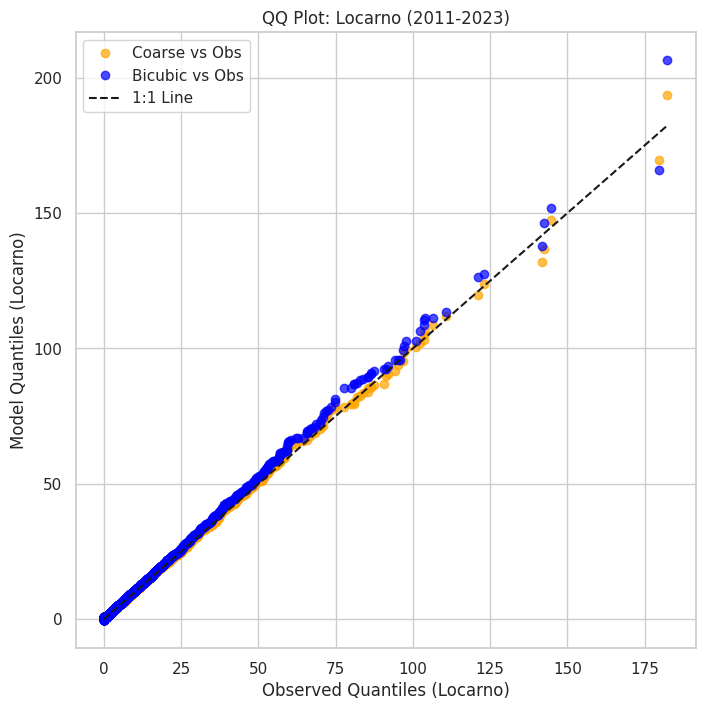

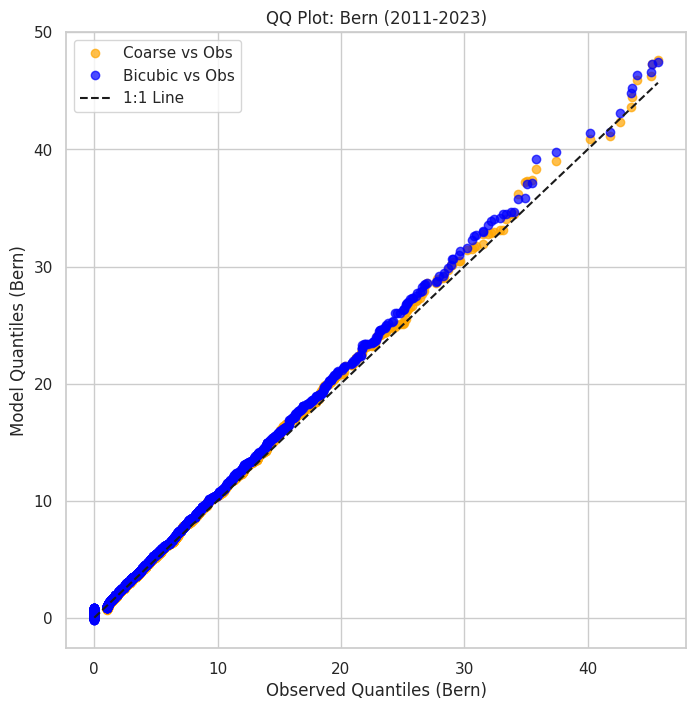

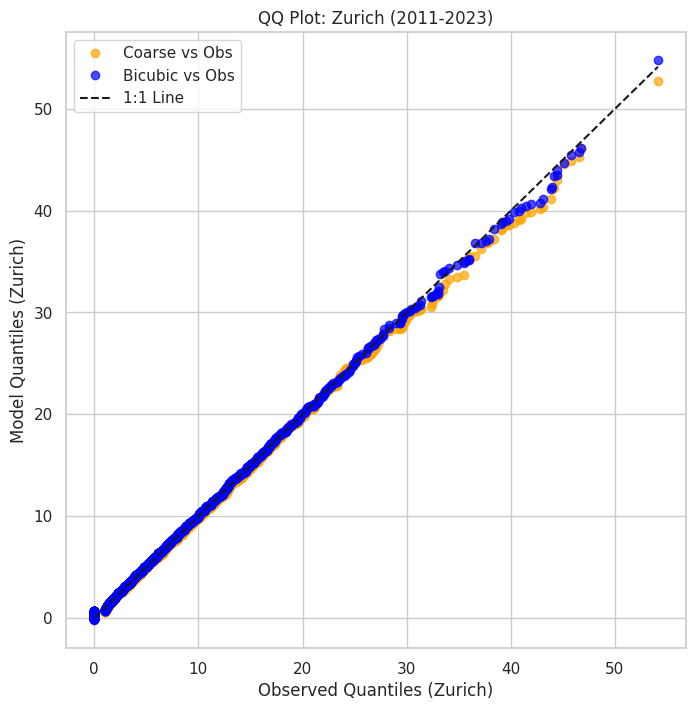

In [32]:
from closest_grid_cell import select_nearest_grid_cell

# City coordinates
locarno_lat, locarno_lon = 46.1709, 8.7995
bern_lat, bern_lon = 46.9480, 7.4474
zurich_lat, zurich_lon = 47.3769, 8.5417

# Open datasets as Dataset, not DataArray
obs_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step1_latlon.nc')
coarse_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step2_coarse.nc')
bicubic_ds = xr.open_dataset(paths.DATASETS_TRAINING_DIR_12km + '/RhiresD_step3_interp.nc')
#unet_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/test_UNet_baseline.nc")
#ldm_ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/LDM_conditional/outputs/single_run_test_LDM_samples.nc")

# Extract time series for Locarno
obs_locarno = select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
coarse_locarno = select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
bicubic_locarno = select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'].values
#unet_locarno = select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values
#ldm_locarno = select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'].values

# Extract time series for Bern
obs_bern = select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
coarse_bern = select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
bicubic_bern = select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="RhiresD")['data'].values
#unet_bern = select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="precip")['data'].values
#ldm_bern = select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'].values



#Extract zurich 
obs_zurich = select_nearest_grid_cell(obs_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values
coarse_zurich = select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values
bicubic_zurich = select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'].values



# Locarno
obs_locarno = clean_and_slice(select_nearest_grid_cell(obs_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
coarse_locarno = clean_and_slice(select_nearest_grid_cell(coarse_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
bicubic_locarno = clean_and_slice(select_nearest_grid_cell(bicubic_ds, locarno_lat, locarno_lon, var_name="RhiresD")['data'])
#unet_locarno = clean_and_slice(select_nearest_grid_cell(unet_ds, locarno_lat, locarno_lon, var_name="precip")['data'])
#ldm_locarno = clean_and_slice(select_nearest_grid_cell(ldm_ds, locarno_lat, locarno_lon, var_name="precip")['data'])

# Bern
obs_bern = clean_and_slice(select_nearest_grid_cell(obs_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
coarse_bern = clean_and_slice(select_nearest_grid_cell(coarse_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
bicubic_bern = clean_and_slice(select_nearest_grid_cell(bicubic_ds, bern_lat, bern_lon, var_name="RhiresD")['data'])
#unet_bern = clean_and_slice(select_nearest_grid_cell(unet_ds, bern_lat, bern_lon, var_name="precip")['data'])
#ldm_bern = clean_and_slice(select_nearest_grid_cell(ldm_ds, bern_lat, bern_lon, var_name="precip")['data'])


#Zurich
obs_zurich = clean_and_slice(select_nearest_grid_cell(obs_ds, zurich_lat    , zurich_lon, var_name="RhiresD")['data'])
coarse_zurich = clean_and_slice(select_nearest_grid_cell(coarse_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'])
bicubic_zurich = clean_and_slice(select_nearest_grid_cell(bicubic_ds, zurich_lat, zurich_lon, var_name="RhiresD")['data'])


# Get common quantiles for Locarno
quantiles_locarno = np.linspace(0, 1, min(len(obs_locarno), len(coarse_locarno), len(bicubic_locarno)))
obs_q_locarno = np.quantile(obs_locarno, quantiles_locarno)
coarse_q_locarno = np.quantile(coarse_locarno, quantiles_locarno)
bicubic_q_locarno = np.quantile(bicubic_locarno, quantiles_locarno)
#unet_q_locarno = np.quantile(unet_locarno, quantiles_locarno)
#ldm_q_locarno = np.quantile(ldm_locarno, quantiles_locarno)

# Get common quantiles for Bern
quantiles_bern = np.linspace(0, 1, min(len(obs_bern), len(coarse_bern), len(bicubic_bern)))
obs_q_bern = np.quantile(obs_bern, quantiles_bern)
coarse_q_bern = np.quantile(coarse_bern, quantiles_bern)
bicubic_q_bern = np.quantile(bicubic_bern, quantiles_bern)
#unet_q_bern = np.quantile(unet_bern, quantiles_bern)
#ldm_q_bern = np.quantile(ldm_bern, quantiles_bern)


#Common quantiles for Zurich
quantiles_zurich = np.linspace(0, 1, min(len(obs_zurich), len(coarse_zurich), len(bicubic_zurich)))
obs_q_zurich = np.quantile(obs_zurich, quantiles_zurich)
coarse_q_zurich = np.quantile(coarse_zurich, quantiles_zurich)
bicubic_q_zurich = np.quantile(bicubic_zurich, quantiles_zurich)


# Plot QQ for Locarno
plt.figure(figsize=(8, 8))
plt.plot(obs_q_locarno, coarse_q_locarno, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_locarno, bicubic_q_locarno, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
#plt.plot(obs_q_locarno, unet_q_locarno, 'o', label='UNet vs Obs', alpha=0.7)
#plt.plot(obs_q_locarno, ldm_q_locarno, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_locarno.min(), obs_q_locarno.max()], [obs_q_locarno.min(), obs_q_locarno.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Locarno)')
plt.ylabel('Model Quantiles (Locarno)')
plt.title('QQ Plot: Locarno (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

# Plot QQ for Bern
plt.figure(figsize=(8, 8))
plt.plot(obs_q_bern, coarse_q_bern, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_bern, bicubic_q_bern, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
#plt.plot(obs_q_bern, unet_q_bern, 'o', label='UNet vs Obs', alpha=0.7)
#plt.plot(obs_q_bern, ldm_q_bern, 'o', label='LDM vs Obs', alpha=0.7)
plt.plot([obs_q_bern.min(), obs_q_bern.max()], [obs_q_bern.min(), obs_q_bern.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Bern)')
plt.ylabel('Model Quantiles (Bern)')
plt.title('QQ Plot: Bern (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()



# Plot QQ for Zurich
plt.figure(figsize=(8, 8))
plt.plot(obs_q_zurich, coarse_q_zurich, 'o', label='Coarse vs Obs', alpha=0.7,color='orange')
plt.plot(obs_q_zurich, bicubic_q_zurich, 'o', label='Bicubic vs Obs', alpha=0.7,color='blue')
plt.plot([obs_q_zurich.min(), obs_q_zurich.max()], [obs_q_zurich.min(), obs_q_zurich.max()], 'k--', label='1:1 Line')
plt.xlabel('Observed Quantiles (Zurich)')
plt.ylabel('Model Quantiles (Zurich)')
plt.title('QQ Plot: Zurich (2011-2023)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import xarray as xr
import numpy as np

# Open the dataset
ds = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Dataset_Setup_I_Chronological_12km/RhiresD_step2_coarse.nc")

# Replace 'TmaxD' with your actual variable name if different
var = ds['RhiresD']

# Create the mask: 1 for valid, 0 for NaN
mask = (~np.isnan(var)).astype(int).isel(time=2)

# Save the mask to a new NetCDF file
mask.to_netcdf("precip_mask_12km.nc")